# ECG Anomaly Detection using Autoencoder with Interpretable Feature Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks, butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
# We used a simplified, pre-processed dataset, ECG5000 dataset from UCI for anomaly detection using Autoencoder and Feature analysis for interpretation
# We donwloaded the dataset through tensorflow library
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
df = pd.read_csv(dataset_url, header=None)

labels = df.iloc[:, -1]
features = df.iloc[:, :-1]

print(f"Dataset loaded. Shape: {features.shape}")
print(f"Labels distribution: \n{labels.value_counts()}")

Dataset loaded. Shape: (4998, 140)
Labels distribution: 
140
1.0    2919
0.0    2079
Name: count, dtype: int64


In [3]:
NORMAL_CLASS = 1
anomalous_labels = labels[labels != NORMAL_CLASS].unique()
normal_beats = features[labels == NORMAL_CLASS]
anomalous_beats = features[labels != NORMAL_CLASS]

print(f"Normal beats shape: {normal_beats.shape}")
print(f"Anomalous beats shape: {anomalous_beats.shape}")

Normal beats shape: (2919, 140)
Anomalous beats shape: (2079, 140)


In [4]:
scaler = StandardScaler()
normal_beats_scaled = scaler.fit_transform(normal_beats)
anomalous_beats_scaled = scaler.transform(anomalous_beats)

In [5]:
X_train_normal, X_val_normal = train_test_split(normal_beats_scaled, test_size=0.2, random_state=42)

In [6]:
print(f"X_train_normal shape: {X_train_normal.shape}")
print(f"X_val_normal shape: {X_val_normal.shape}")

X_train_normal shape: (2335, 140)
X_val_normal shape: (584, 140)


In [7]:
input_dim = X_train_normal.shape[1]
latent_dim = 16

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
latent_representation = Dense(latent_dim, activation='relu')(encoder)

# Decode
decoded = Dense(32, activation='relu')(latent_representation)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

print("\nAutoencoder model summary:")
autoencoder.summary()


Autoencoder model summar:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         9,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 140)            │         9,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,388 (91.36 KB)

 Trainable params: 23,388 (91.36 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_normal, X_val_normal),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9040 - val_loss: 0.4396
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3701 - val_loss: 0.2955
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2865 - val_loss: 0.2440
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2358 - val_loss: 0.2220
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2400 - val_loss: 0.1938
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1866 - val_loss: 0.1804
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1852 - val_loss: 0.1640
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1680 - val_loss: 0.1512
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1478 - val_loss: 0.1447
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1532 - val_loss: 0.1383
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1493 - val_loss: 0.1361
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1425 - val_lo

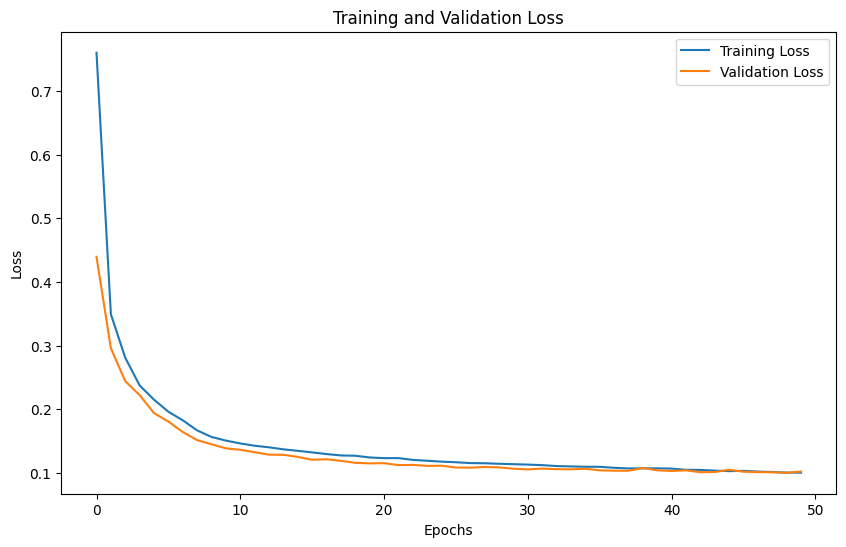

In [9]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Predict on all normal data
reconstructions_normal = autoencoder.predict(normal_beats_scaled)
mse_normal = np.mean(np.square(normal_beats_scaled - reconstructions_normal), axis=1)

# Predict on all anomalous data
reconstructions_anomalous = autoencoder.predict(anomalous_beats_scaled)
mse_anomalous = np.mean(np.square(anomalous_beats_scaled - reconstructions_anomalous), axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


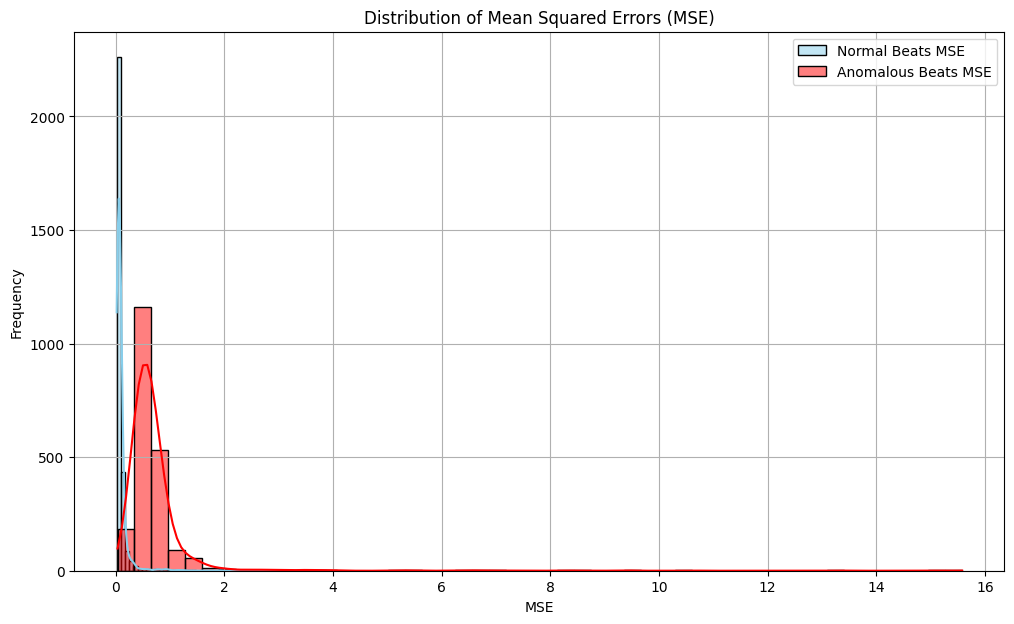

In [11]:
plt.figure(figsize=(12,7))
sns.histplot(mse_normal, bins=50, kde=True, color='skyblue', label='Normal Beats MSE')
sns.histplot(mse_anomalous, bins=50, kde=True, color='red', label='Anomalous Beats MSE')
plt.title('Distribution of Mean Squared Errors (MSE)')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
threshold = np.mean(mse_normal) + 3 * np.std(mse_normal)
print(f"Threshold for normal beats: {threshold:.4f}")

Threshold for normal beats: 0.7205


In [13]:
is_anomaly_normal = mse_normal > threshold
is_anomaly_anomalous = mse_anomalous > threshold

print(f"Number of normal beats classified as anomalies: {is_anomaly_normal.sum()}")
print(f"Number of anomalous beats classified as normal: {is_anomaly_anomalous.sum()}")

Number of normal beats classified as anomalies: 46
Number of anomalous beats classified as normal: 552


In [14]:
Y_true_combined = np.concatenate([np.zeros(len(normal_beats_scaled)), np.ones(len(anomalous_beats_scaled))])
Y_pred_combined = np.concatenate([is_anomaly_normal, is_anomaly_anomalous])

cm = confusion_matrix(Y_true_combined, Y_pred_combined)
cr = classification_report(Y_true_combined, Y_pred_combined)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

Confusion Matrix:
[[2873   46]
 [1527  552]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.98      0.79      2919
         1.0       0.92      0.27      0.41      2079

    accuracy                           0.69      4998
   macro avg       0.79      0.62      0.60      4998
weighted avg       0.77      0.69      0.63      4998



<Figure size 800x600 with 0 Axes>

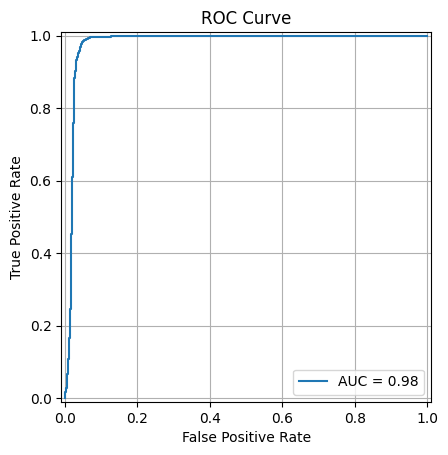

In [15]:
fpr, tpr, _ = roc_curve(Y_true_combined, np.concatenate([mse_normal, mse_anomalous]))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [16]:
normal_beats_df = pd.DataFrame(normal_beats_scaled, columns=[f'feature_{i}' for i in range(input_dim)])
anomalous_beats_df = pd.DataFrame(anomalous_beats_scaled, columns=[f'feature_{i}' for i in range(input_dim)])


552 actual anomalies detected by the model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


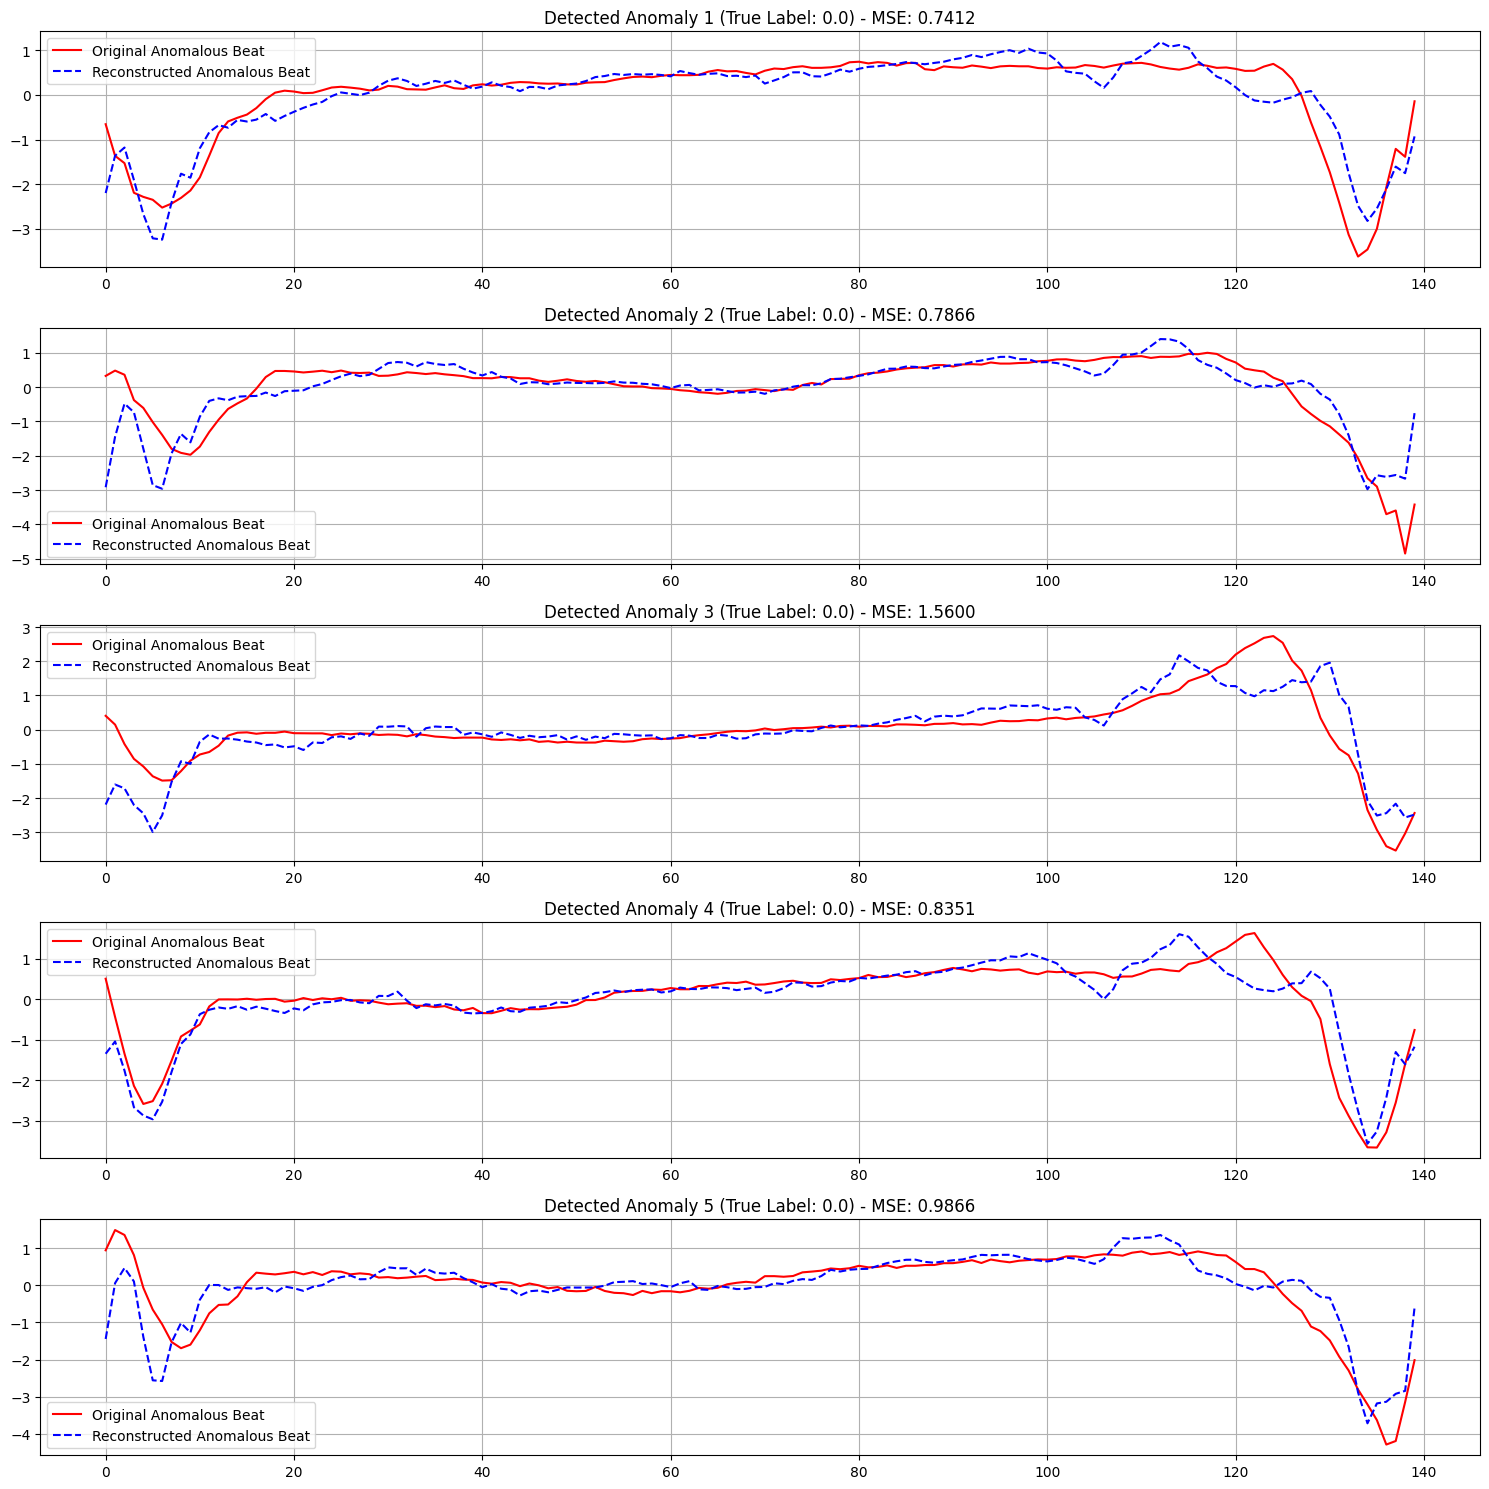


Extracting interpretable features for analysis...


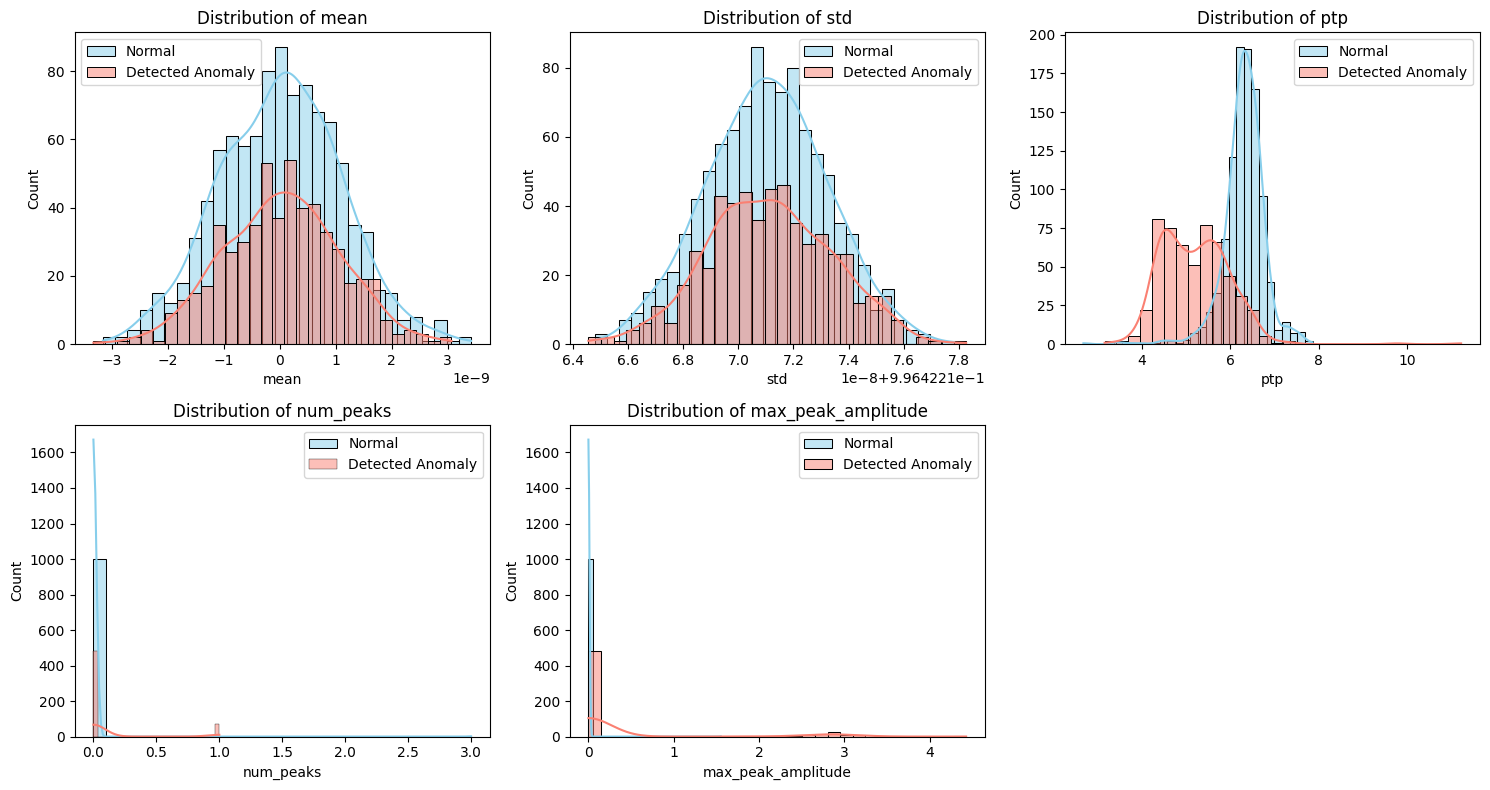


--- Insights from Feature Analysis ---
Comparing statistical properties of detected anomalous beats vs. normal beats:
Mean of Normal Features:
 mean                  1.105000e-11
std                   9.964222e-01
max                   2.034725e+00
min                  -4.273654e+00
ptp                   6.308378e+00
rms                   9.964222e-01
num_peaks             3.000000e-03
max_peak_amplitude    1.550497e-03
dtype: float64

Mean of Detected Anomaly Features:
 mean                  2.931501e-11
std                   9.964222e-01
max                   1.639419e+00
min                  -3.565911e+00
ptp                   5.205330e+00
rms                   9.964222e-01
num_peaks             1.304348e-01
max_peak_amplitude    3.686039e-01
dtype: float64

Standard Deviation of Normal Features:
 mean                  1.084899e-09
std                   2.182701e-09
max                   2.949927e-01
min                   4.276175e-01
ptp                   4.706726e-01
rms         

In [17]:
detected_anomalies_indices = np.where(is_anomaly_anomalous)[0]
if len(detected_anomalies_indices) > 0:
  sample_detected_anomalies_scaled = anomalous_beats_scaled[detected_anomalies_indices]
  sample_detected_anomalies_original = scaler.inverse_transform(sample_detected_anomalies_scaled)
  print(f"\n{len(detected_anomalies_indices)} actual anomalies detected by the model.")

  num_to_visualize = min(5, len(detected_anomalies_indices))
  random_anomalies_idx = np.random.choice(len(detected_anomalies_indices), size=num_to_visualize, replace=False)

  plt.figure(figsize=(15, num_to_visualize * 3))
  for i, anomaly_idx_in_detected in enumerate(random_anomalies_idx):
    original_idx = detected_anomalies_indices[anomaly_idx_in_detected]
    original_beat = anomalous_beats.iloc[original_idx].values
    reconstructed_beat = autoencoder.predict(anomalous_beats_scaled[original_idx:original_idx+1])[0]
    reconstructed_beat_original_scale = scaler.inverse_transform(reconstructed_beat.reshape(1, -1))[0]

    plt.subplot(num_to_visualize, 1, i + 1)
    plt.plot(original_beat, label='Original Anomalous Beat', color='red')
    plt.plot(reconstructed_beat_original_scale, label='Reconstructed Anomalous Beat', linestyle='--', color='blue')
    plt.title(f'Detected Anomaly {i+1} (True Label: {labels[labels != NORMAL_CLASS].iloc[original_idx]}) - MSE: {mse_anomalous[original_idx]:.4f}')
    plt.legend()
    plt.grid(True)
  plt.tight_layout()
  plt.show()

  # --- Feature analysis for detected anomalies ---

  def extract_simple_features(ecg_segment):
    features = {}
    features['mean'] = np.mean(ecg_segment)
    features['std'] = np.std(ecg_segment)
    features['max'] = np.max(ecg_segment)
    features['min'] = np.min(ecg_segment)
    features['ptp'] = np.ptp(ecg_segment)
    features['rms'] = np.sqrt(np.mean(np.square(ecg_segment)))

    peaks, _ = find_peaks(ecg_segment, height=(0.5*features['ptp'], None), distance=10)
    features['num_peaks'] = len(peaks)
    if len(peaks) > 0:
      features['max_peak_amplitude'] = np.max(ecg_segment[peaks])
    else:
      features['max_peak_amplitude'] = 0

    return features

  print ("\nExtracting interpretable features for analysis...")
  normal_original_beats_sampled = normal_beats.sample(n=min(len(normal_beats), 1000), random_state=42)
  detected_anomalies_original_beats = anomalous_beats.iloc[detected_anomalies_indices]

  normal_features_list = [extract_simple_features(beat) for _, beat in normal_original_beats_sampled.iterrows()]
  anomaly_features_list = [extract_simple_features(beat) for _, beat in detected_anomalies_original_beats.iterrows()]


  normal_features_df = pd.DataFrame(normal_features_list)
  anomaly_features_df = pd.DataFrame(anomaly_features_list)

  if not anomaly_features_df.empty:
    feature_names = ['mean', 'std', 'ptp', 'num_peaks', 'max_peak_amplitude']
    plt.figure(figsize=(15,8))
    for i, feature in enumerate(feature_names):
      plt.subplot(2, 3, i+1)
      sns.histplot(normal_features_df[feature], bins=30, kde=True, color='skyblue', label='Normal')
      sns.histplot(anomaly_features_df[feature], bins=30, kde=True, color='salmon', label='Detected Anomaly')
      plt.title(f'Distribution of {feature}')
      plt.xlabel(feature)
      plt.ylabel('Count')
      plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Insights from Feature Analysis ---")
    print("Comparing statistical properties of detected anomalous beats vs. normal beats:")
    print("Mean of Normal Features:\n", normal_features_df.mean())
    print("\nMean of Detected Anomaly Features:\n", anomaly_features_df.mean())
    print("\nStandard Deviation of Normal Features:\n", normal_features_df.std())
    print("\nStandard Deviation of Detected Anomaly Features:\n", anomaly_features_df.std())

    print("\nLook for features where the mean/std for 'Detected Anomaly' significantly deviates from 'Normal'.")
    print("For instance, anomalies might have higher 'std' (more erratic), different 'ptp' (different amplitude range), or unexpected 'num_peaks'.")
  else:
    print("\nNo anomalies were detected by the model to perform feature analysis.")

In [28]:
# --- Saving Model and Results (for Portfolio) ---
# autoencoder.save('ecg_autoencoder_model.h5') # Saves the model in HDF5 format